<a href="https://colab.research.google.com/github/JGillette71/BERT-Inferred_Minor_Status/blob/main/data_augmentation_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Prep

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Read fine tuning data 
part1 = pd.read_csv('/content/drive/MyDrive/Grad School Projects /ner_data/Annotations/IOB_edited_part_1.txt',sep='\t')
part2 = pd.read_csv('/content/drive/MyDrive/Grad School Projects /ner_data/Annotations/IOB_edited_part_2.txt',sep='\t')

# concat data partitions 
word_data = pd.concat([part1, part2], ignore_index=True)
word_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507517 entries, 0 to 507516
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sentence  0 non-null       float64
 1   token     501905 non-null  object 
 2   label     501907 non-null  object 
dtypes: float64(1), object(2)
memory usage: 11.6+ MB


In [ ]:
# how many stop tokens / stories? 
stops_removed = len(word_data[(word_data['token'].str.contains('stop-x')) & (word_data['label'].str.contains('stop-x'))])
print(f'{stops_removed} stop tokens in data')

# how null values? 
empty_rows = word_data.isna().values.sum()
print(f'{empty_rows} empty values in data')

4224 stop tokens in data
518739 empty values in data


In [ ]:
# cast sentence label column as object to facilitate str fill 
word_data['sentence'] = word_data['sentence'].astype(object)

# set first sentence label 
word_data.at[0, 'sentence'] = ('sentence 0')

# label sentence where stop value 
num = 0 
for i in range(len(word_data)): 
  if (word_data.at[i, 'token'] == 'stop-x') & (word_data.at[i, 'label'] == 'stop-x'):
    num += 1
    word_data.at[i, 'sentence'] = (f'sentence {num}')

# check known location for sentence number addition 
print(word_data.iloc[65])

sentence    sentence 1
token           stop-x
label           stop-x
Name: 65, dtype: object


In [ ]:
# forward fill all the sentece labels 
word_data['sentence'].ffill(inplace=True)
word_data.tail()

,sentence,token,label
507512,sentence 4222,in,O
507513,sentence 4222,positive,O
507514,sentence 4222,way,O
507515,sentence 4222,.,O
507516,sentence 4223,stop-x,stop-x


In [ ]:
# drop stop values 
word_data = word_data[(word_data['token'].str.contains('stop-x')) & (word_data['label'].str.contains('stop-x'))== False]

# drop empty values
word_data.dropna(axis=0, how='any', inplace=True)

# reset index
word_data.reset_index(drop=True, inplace=True)
word_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497680 entries, 0 to 497679
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  497680 non-null  object
 1   token     497680 non-null  object
 2   label     497680 non-null  object
dtypes: object(3)
memory usage: 11.4+ MB


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
# how many stop tokens / stories? 
stops_removed = len(word_data[(word_data['token'].str.contains('stop-x')) & (word_data['label'].str.contains('stop-x'))])
print(f'{stops_removed} stop tokens in data')

# how null values? 
empty_rows = word_data.isna().values.sum()
print(f'{empty_rows} empty values in data')

0 stop tokens in data
0 empty values in data


In [ ]:
# check for anomalous tokens w/ str length
# a bad delimeter can cause strings to bunch up
word_data['token_Length'] = word_data['token'].map(len)

# summary of lengths and 10 largest
print(word_data['token_Length'].describe())
print(word_data.nlargest(10, 'token_Length'))

# ditch the token length column after use
word_data.drop(labels='token_Length', axis='columns', inplace= True)

count    497680.000000
mean          4.275643
std           2.490076
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          19.000000
Name: token_Length, dtype: float64
             sentence                token  label  token_Length
415424  sentence 3444  interdenominational      O            19
104093   sentence 284   operationalization      O            18
276374  sentence 1898   operationalization      O            18
33946    sentence 117    telecommunication      O            17
33951    sentence 117    Telecommunication  I-ORG            17
123477   sentence 522    telecommunication      O            17
235882  sentence 1546    misunderstandings      O            17
313556  sentence 2340    telecommunication      O            17
320482  sentence 2441    Commercialisation  I-ORG            17
339910  sentence 2658    counterproductive      O            17


Now dropping Organizations, Other, and Locations...

### Minority Class Over-sampling 
To address significant calss imbalance, train_df will be sampled multiple times and subjected to entity substitution in order to augment. 

In [ ]:
# check initial class imbalance 
word_data['label'].value_counts()

O         456783
I-ORG      13008
B-ORG       7674
B-LOC       7319
B-ADLT      4910
I-LOC       3187
I-ADLT      2040
B-MINR      1549
I-OTHR       608
B-OTHR       384
I-MINR       218
Name: label, dtype: int64

O 456,783 \
org 7,674 + 13,008 = 20,682 \
loc 7,319 + 3,187 = 10,506 \
adlt 4,910 + 2,040 = 6,950 \
minr 1,549 + 218 = 1,767 \
othr 384 + 608 = 992 \

In [ ]:
# filter to sentences containing B-MINR 
# accompanying entities provide relative balance

# sample all instances of minors
minr_df1 = word_data[word_data['label'] == 'B-MINR'].copy()
print(f'Shape of B-MINR dataframe: {minr_df1.shape}')

# identify coresponding sentence numbers and cast to list
minr_df1.drop_duplicates(subset='sentence', inplace= True, ignore_index= True)
minr_sentences = minr_df1['sentence'].to_list()
print(f'sentences containing B-MINR: {len(minr_sentences)}')

# drop all sentences that do not contain B-MINR 
word_data = word_data[word_data['sentence'].isin(minr_sentences)]
word_data.reset_index(drop=True, inplace=True)
word_data.info()

Shape of B-MINR dataframe: (1549, 3)
sentences containing B-MINR: 511
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119911 entries, 0 to 119910
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  119911 non-null  object
 1   token     119911 non-null  object
 2   label     119911 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


In [ ]:
# check on resulting balance
word_data['label'].value_counts()

O         111112
I-ORG       2202
B-MINR      1549
B-ORG       1323
B-LOC       1210
B-ADLT      1124
I-LOC        553
I-ADLT       367
I-MINR       218
I-OTHR       158
B-OTHR        95
Name: label, dtype: int64

minr 1,549 + 218 = 1,767 \
adlt 1,124 + 367 = 1,491 \

Finer balance, but very limited data. Must augment multiple copies. 

### Training / Testing Split 

In [ ]:
# how many unique sentences 
print(f'unique sentences containing minors: {word_data.sentence.nunique()}')

# training / testing split
train_size = 0.8
minr_sentences = pd.Series(minr_sentences)
train_sentences = minr_sentences.sample(frac=train_size,random_state=200)
train_df = word_data[word_data['sentence'].isin(train_sentences)]
train_df.reset_index(drop=True, inplace=True)
test_df = word_data[~word_data['sentence'].isin(train_sentences)]
test_df.reset_index(drop=True, inplace=True)

print("FULL Dataset: {}".format(word_data.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

unique sentences containing minors: 511
FULL Dataset: (119911, 3)
TRAIN Dataset: (98183, 3)
TEST Dataset: (21728, 3)


In [ ]:
# unique sentences
print(f'unique sentences in training set: {train_df.sentence.nunique()}')
print(f'unique sentences in testing set: {test_df.sentence.nunique()}')

unique sentences in training set: 409
unique sentences in testing set: 102


In [ ]:
 # 5x copy of datasets w/ seperate training and testing

train_df2 = train_df.copy()
train_df3 = train_df.copy()
train_df4 = train_df.copy()
train_df5 = train_df.copy()

test_df2 = test_df.copy()
test_df3 = test_df.copy()
test_df4 = test_df.copy()
test_df5 = test_df.copy()

### Data Augmentation
One-to-one substitute entities w/ randomly generated names. 

Purpose of this method is to balance and expand available training data while maintaining token-lable alignment. 

In [ ]:
pip install faker

In [ ]:
# feed all tagged words through substitution pipeline 
from faker import Faker

def aug_data(dataframe):
  # find indexes for substitution
  bminr_index = dataframe.index[dataframe['label'] == 'B-MINR'].tolist()
  iminr_index = dataframe.index[dataframe['label'] == 'I-MINR'].tolist()
  badlt_index = dataframe.index[dataframe['label'] == 'B-ADLT'].tolist()
  iadlt_index = dataframe.index[dataframe['label'] == 'I-ADLT'].tolist()
  bloc_index = dataframe.index[dataframe['label'] == 'B-LOC'].tolist()
  iloc_index = dataframe.index[dataframe['label'] == 'I-LOC'].tolist()
  borg_index = dataframe.index[dataframe['label'] == 'B-ORG'].tolist()

  # substitute all minor names
  # e.g. Victor becomes Patty, etc.  
  for i in bminr_index:
    replacement_name = Faker().first_name()
    dataframe.at[i, 'token'] = replacement_name

  # substitute all minor names 
  for i in iminr_index:
    replacement_name = Faker().last_name()
    dataframe.at[i, 'token'] = replacement_name

  # substitute all adult names 
  for i in badlt_index:
    replacement_name = Faker().first_name()
    dataframe.at[i, 'token'] = replacement_name

  # substitute all adult names 
  for i in iadlt_index:
    replacement_name = Faker().last_name()
    dataframe.at[i, 'token'] = replacement_name

  # substitute all location names 
  # e.g. Nairobi becomes Johnville 
  for i in bloc_index:
    replace_prefix = Faker().first_name()
    replace_suffix = Faker().city_suffix()
    replacement_loc = replace_prefix+replace_suffix
    dataframe.at[i, 'token'] = replacement_loc

  # substitute all location names 
  for i in iloc_index:
    replacement_loc = Faker().country()
    # cheap way to deal with multi-token cases
    loc_list = replacement_loc.split(' ')
    dataframe.at[i, 'token'] = loc_list[0]

  # substitute all org begining
  # e.g. General Motors becomes Dixon Motors 
  for i in borg_index:
    replacement_org = Faker().last_name()
    dataframe.at[i, 'token'] = replacement_org
  
  return(dataframe)

In [ ]:
# organize df copies 
train_df_list = [train_df, train_df2, train_df3, train_df4, train_df5]
test_df_list = [test_df, test_df2, test_df3, test_df4, test_df5]

# augment training copies 
# first copy doesn't need to be augmented
for index, df in enumerate(train_df_list[1:]):
  df = aug_data(df)
  print(f'train df{index+2} augment complete')

# augment testing copies 
for index, df in enumerate(test_df_list[1:]):
  df = aug_data(df)
  print(f'test df{index+2} augment complete')

train df2 augment complete
train df3 augment complete
train df4 augment complete
train df5 augment complete
test df2 augment complete
test df3 augment complete
test df4 augment complete


Exception ignored in: <function ZipFile.__del__ at 0x7f0e0dda2e60>
Traceback (most recent call last):
  File "/usr/lib/python3.7/zipfile.py", line 1809, in __del__
    self.close()
  File "/usr/lib/python3.7/zipfile.py", line 1826, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


test df5 augment complete


In [ ]:
# Check known token for substitution
print(train_df['token'][242])
print(train_df2['token'][242])
print(train_df3['token'][242])
print(train_df4['token'][242])
print(train_df5['token'][242])

school
school
school
school
school


In [ ]:
train_df

,sentence,token,label
0,sentence 10,Stealing,O
1,sentence 10,is,O
2,sentence 10,the,O
3,sentence 10,taking,O
4,sentence 10,of,O
...,...,...,...
98178,sentence 4216,me,O
98179,sentence 4216,uncle,O
98180,sentence 4216,steve,B-ADLT
98181,sentence 4216,said,O


### Consolidate Data and Labels

In [ ]:
# remove ORG and OTHR labels; not being used
for df in train_df_list + test_df_list:
  df.replace(to_replace=['B-ORG', 'I-ORG', 'B-OTHR', 'I-OTHR', 'B-LOC', 'I-LOC'], value='O', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
# join tokens into sentence groups and label groups 
# populate full sentences by grouping on sentence number and joining words

def seq_from_word(df):
  df['sentence_list'] = df[['sentence','token','label']].groupby(['sentence'])['token'].transform(lambda x: ' '.join(x))

  # let's also create a new column called "word_labels" which groups the tags by sentence 
  df['label_list'] = df[['sentence','token','label']].groupby(['sentence'])['label'].transform(lambda x: ','.join(x))

  # populate sequences into new data frame
  #df = df[['sentence_list', 'label_list']].copy()
  df.drop(['sentence', 'token', 'label'], axis=1, inplace= True)

  # drop all the duplicate sentences created by the join method 
  df.drop_duplicates(subset='sentence_list', inplace= True, ignore_index= True)


# call the sequence function
for index, item in enumerate(train_df_list + test_df_list):
  item = seq_from_word(item)
  print(f'{index+1} df sequencing complete')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

1 df sequencing complete
2 df sequencing complete
3 df sequencing complete
4 df sequencing complete
5 df sequencing complete
6 df sequencing complete
7 df sequencing complete
8 df sequencing complete
9 df sequencing complete
10 df sequencing complete


In [ ]:
# concat data partitions 
train_data = pd.concat(train_df_list, ignore_index=True)
train_data.info()

test_data = pd.concat(test_df_list, ignore_index=True)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentence_list  2027 non-null   object
 1   label_list     2027 non-null   object
dtypes: object(2)
memory usage: 31.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentence_list  507 non-null    object
 1   label_list     507 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [ ]:
# write training data for later use
train_data.to_excel('/content/drive/MyDrive/Grad School Projects /training_data_v3.xlsx', index=False)

In [ ]:
# write testing data for later use
test_data.to_excel('/content/drive/MyDrive/Grad School Projects /testing_data_v3.xlsx', index=False)

### Analysis

In [ ]:
train_data.head()

,sentence_list,label_list
0,Stealing is the taking of someone 's property ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
1,Kanyeki was a student at Olkesuke primary scho...,"B-MINR,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O..."
2,There was a boy living up country by a name ca...,"O,O,O,O,O,O,O,O,O,O,O,B-MINR,I-MINR,O,O,O,O,O,..."
3,I am Petronila Wilunda . I am currently on a b...,"O,O,B-MINR,I-MINR,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,"My name is Jane Wilunda , from Kakamega North ...","O,O,O,B-MINR,I-MINR,O,O,O,O,O,O,O,O,O,O,O,O,O,..."


In [ ]:
test_data.head()

,sentence_list,label_list
0,In my village there lived a teenager who lived...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
1,"This Kiswahili saying watu , watu wengi lakini...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-MINR,O,O,O..."
2,"Njuguna , a corrupted young man with infinite ...","B-MINR,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O..."
3,My name is Sabina Khavai I did my K. C. P. E. ...,"O,O,O,B-MINR,I-MINR,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,My name is Jessica Nyongesa from kakamega nort...,"O,O,O,B-MINR,I-MINR,O,O,O,O,O,O,O,O,B-MINR,I-M..."


In [ ]:
# look for overlap between train and test sets
for row in range(len(train_data)):
    dup_check = (train_data.iloc[row, ].values == test_data.values).all()
np.count_nonzero(dup_check)

0

O         475825
B-MINR      5951
B-ADLT      4871
I-ADLT      1537
I-MINR       831
dtype: int64


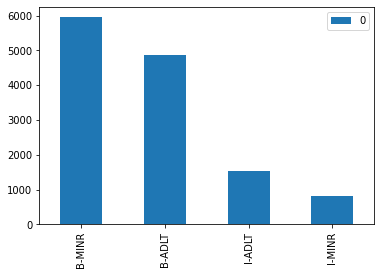

In [ ]:
# convert to list
train_data['label_list'] = train_data['label_list'].apply(lambda x: list(x.split(',')))

# perform count of entity instances
entity_counts = pd.Series([x for item in train_data['label_list'] for x in item]).value_counts()
print(entity_counts)

# plot entity counts
entity_count_df = entity_counts.to_frame()
entity_count_df.drop(labels='O', axis=0, inplace=True)
entity_count_df.plot(kind='bar')

8735 MINR vs 7420 ADLT totals; slight imbalance. Not as imbalanced as version 1 entities which got +80% F1 on adults and +70% in minors. 

O         105302
B-MINR      1733
B-ADLT       739
I-ADLT       290
I-MINR       255
dtype: int64


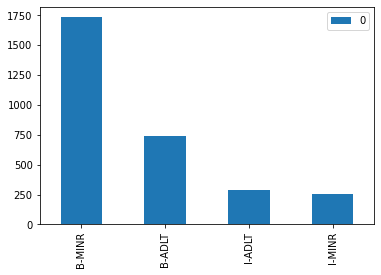

In [ ]:
# convert to list
test_data['label_list'] = test_data['label_list'].apply(lambda x: list(x.split(',')))

# perform count of entity instances
entity_counts = pd.Series([x for item in test_data['label_list'] for x in item]).value_counts()
print(entity_counts)

# plot entity counts
entity_count_df = entity_counts.to_frame()
entity_count_df.drop(labels='O', axis=0, inplace=True)
entity_count_df.plot(kind='bar')